I want to learn how to know how big (depth, max_seq_len) a model I can create and have it still fit on my GPU.

In [1]:
import torch
import gc

### Toy example

Let me start by seeing if I can understand it for a simple model.

In [2]:
torch.cuda.is_available()

True

In [3]:
free, total = torch.cuda.mem_get_info()
free, total

(8249999360, 8354660352)

In [4]:
print(f"Free memory: {free / 1024**3:.2f} GB")
print(f"Total memory: {total / 1024**3:.2f} GB")

Free memory: 7.68 GB
Total memory: 7.78 GB


In [5]:
allocated = torch.cuda.memory_allocated()
allocated

0

In [6]:
free_before = free

In [7]:
model = torch.nn.Linear(in_features=10, out_features=10, bias=False, device="cuda", dtype=torch.float32)

In [8]:
# this should have 100 params, each 32 bits = 4 bytes, so guessing consumes this many bytes:
100 * 4

400

In [9]:
free, total = torch.cuda.mem_get_info()
free_before - free

4194304

In [10]:
torch.cuda.memory_allocated()

512

Is the 512 because it allocates in certain minimum units? Let's try a few things.

In [11]:
del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

0

In [12]:
# first confirm repeatable
model = torch.nn.Linear(in_features=10, out_features=10, bias=False, device="cuda", dtype=torch.float32)
torch.cuda.memory_allocated()

512

In [13]:
del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

0

In [14]:
# 11 x 11 x 4 = 484, so guessing we'll still see 512
model = torch.nn.Linear(in_features=11, out_features=11, bias=False, device="cuda", dtype=torch.float32)

In [15]:
torch.cuda.memory_allocated()

512

In [20]:
del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

0

In [21]:
# 12 x 12 x 4 = 576, so guessing we'll still see 1024
model = torch.nn.Linear(in_features=12, out_features=12, bias=False, device="cuda", dtype=torch.float32)

In [22]:
torch.cuda.memory_allocated()

1024

What about the gradient? Does that space get allocated only as needed? Let's try.

In [25]:
x = torch.randn(12, device="cuda")

In [26]:
torch.cuda.memory_allocated()
# 1024 + 512 = 1636

1536

In [27]:
loss = model(x).sum()

In [28]:
torch.cuda.memory_allocated()

8521728

What's that all about? Is that memory that gets allocated to do the forward pass? Maybe we should start even simpler and see what happens if we allocte two tensors and multiply them. But first see what happens when we call backward().

In [31]:
loss.backward()

In [32]:
torch.cuda.memory_allocated()

17042432

In [37]:
model.weight.grad

tensor([[ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.

In [47]:
model.weight.untyped_storage().nbytes()

576

In [48]:
model.weight.grad.untyped_storage().nbytes()

576

In [49]:
x.untyped_storage().nbytes()

48

In [50]:
loss.untyped_storage().nbytes()

4

Maybe it's not such a good idea to try to line things up at this level with `torch.cuda.memory_allocated()` because torch (or lower-level stuff?) could be allocating caches, etc. Let's see how things work with bigger numbers. But first, let's see what happens with allocating and multiplying raw tensors. My hope is there the numbers will match up.

Also, could jupyter be holding onto things?

In [1]:
## restart kernel ##
import torch
import gc

In [2]:
torch.cuda.memory_allocated()

0

In [3]:
m = torch.randn(12, 12, device="cuda", dtype=torch.float32)

In [4]:
torch.cuda.memory_allocated()

1024

In [5]:
m.untyped_storage().nbytes()

576

In [6]:
x = torch.randn(12, device="cuda", dtype=torch.float32)

In [7]:
torch.cuda.memory_allocated() # expecting 1024 + 512 = 1536

1536

In [8]:
y = m @ x

In [9]:
torch.cuda.memory_allocated() # expecting 1024 + 512 + 512 = 2048

8521728

No. Maybe as soon as you do matrix math it allocates memory for something?

In [11]:
torch.cuda.empty_cache()

In [12]:
torch.cuda.memory_allocated()

8521728

Does torch.no_grad() matter?

In [1]:
## restart kernel ##
import torch
import gc
torch.cuda.memory_allocated()

0

In [2]:
m = torch.randn(12, 12, device="cuda", dtype=torch.float32)
x = torch.randn(12, device="cuda", dtype=torch.float32)

In [3]:
torch.cuda.memory_allocated()

1536

In [4]:
with torch.no_grad():
    y = m @ x

In [5]:
torch.cuda.memory_allocated()

8521728

How about preallocating space for the result?

In [1]:
## restart kernel ##
import torch
import gc
torch.cuda.memory_allocated()

0

In [2]:
m = torch.randn(12, 12, device="cuda", dtype=torch.float32)
x = torch.randn(12, device="cuda", dtype=torch.float32)
y = torch.empty_like(x)

In [3]:
torch.cuda.memory_allocated()

2048

In [4]:
foo = torch.matmul(m, x, out=y)
del foo
gc.collect()
torch.cuda.empty_cache()

In [5]:
torch.cuda.memory_allocated()

8521728

Not sure, let's try with much bigger numbers and see. Maybe the unaccounted for stuff is fixed stuff that will become a rounding error at bigger sizes.

In [1]:
## restart kernel ##
import torch
import gc
torch.cuda.memory_allocated()

0

In [2]:
m = torch.randn(1000, 1000, device="cuda", dtype=torch.float32) # 4,000,000 bytes
x = torch.randn(1000, device="cuda", dtype=torch.float32) # 4000 bytes

In [3]:
torch.cuda.memory_allocated()

4004352

In [4]:
m.untyped_storage().nbytes(), x.untyped_storage().nbytes()

(4000000, 4000)

In [5]:
y = m @ x

In [7]:
y.untyped_storage().nbytes()

4000

In [6]:
torch.cuda.memory_allocated()

12528128

No. It jumps from ~4M to ~12M. Why?

In [9]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

12528128

What if the tensors large enough that they and the result take up all the space?

In [1]:
## restart kernel ##
import torch
import gc
torch.cuda.memory_allocated()

0

In [2]:
free, total = torch.cuda.mem_get_info()
f"{free:,}"

'8,249,999,360'

In [3]:
import math
math.sqrt(free / 4)

45414.753549920315

In [4]:
m = torch.randn(40_000, 40_000, device="cuda", dtype=torch.float32)
x = torch.randn(40_000, device="cuda", dtype=torch.float32)

In [5]:
m.untyped_storage().nbytes() + x.untyped_storage().nbytes()

6400160000

In [6]:
f"{torch.cuda.memory_allocated():,}"

'6,400,668,160'

In [7]:
y = m @ x

In [8]:
y.untyped_storage().nbytes()

160000

In [9]:
f"{torch.cuda.memory_allocated():,}"

'6,409,348,096'

In [10]:
free, total = torch.cuda.mem_get_info()
f"{free:,}"

'1,813,839,872'

well, that worked, and the "extra" increase after the multiplication was "only" ~9M:

In [11]:
torch.cuda.memory_allocated() - (m.untyped_storage().nbytes() + x.untyped_storage().nbytes() + y.untyped_storage().nbytes())

9028096

so maybe it's not worth worrying about exactly how this works, but what happens if we go back to the simple linear model with the same large number of params. Will the forward pass work but it will fail with an out of memory problem when call backward() because it doesn't have room to store the gradient?

In [1]:
## restart kernel ##
import torch
import gc
torch.cuda.memory_allocated()

0

In [2]:
model = torch.nn.Linear(in_features=40_000, out_features=40_000, bias=False, device="cuda", dtype=torch.float32)

In [3]:
f"{torch.cuda.memory_allocated():,}"

'6,400,507,904'

In [4]:
x = torch.randn(40_000, device="cuda", dtype=torch.float32)

In [5]:
f"{torch.cuda.memory_allocated():,}"

'6,400,668,160'

In [6]:
loss = model(x).sum()

In [7]:
f"{torch.cuda.memory_allocated():,}"

'6,409,188,352'

In [8]:
loss.backward()

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.96 GiB. GPU 0 has a total capacity of 7.78 GiB of which 1.68 GiB is free. Including non-PyTorch memory, this process has 6.10 GiB memory in use. Of the allocated memory 5.97 GiB is allocated by PyTorch, and 13.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### bfloat16

Another thing I want to understand before digging into the real model is bfloat16.

I ended up spending way more time than the few minutes I thought it would take to see how torch.float32 works and moved the explortation to `understand-torch-float32.ipynb`. If nothing else I'll be more cautious about numerical precision and understand that float are not magical, for example, why the way the encoding works causes the following:

In [715]:
torch.tensor(12345678912, dtype=torch.float32).item()

12345678848.0

In [707]:
torch.tensor(1.2345e-20, dtype=torch.float32).item()

1.2345000173693373e-20

In [711]:
torch.tensor(1.2345678e-5, dtype=torch.float32).item()

1.2345678442216013e-05

In [713]:
torch.tensor(1.2345678e5, dtype=torch.float32).item()

123456.78125

### "Hand" calculate memory for the gpt model

Let's use the sizes from the baby pretrain notebook

In [5]:
import matplotlib.pyplot as plt

In [6]:
# example config

depth = 4
max_seq_len = 128

num_layers = depth
model_dim = depth * 64 # 256
num_heads = max(1, (model_dim + 127) // 128)
num_kv_heads = num_heads # 2

vocab_size = 65537

device_batch_size = 1
total_batch_size = device_batch_size * max_seq_len

In [7]:
n_wte_params = vocab_size * model_dim
n_attn_params = num_layers * 4 * model_dim * model_dim # (c_q, c_k, c_v, c_proj)
n_mlp_params = num_layers * 2 * model_dim * 4 * model_dim # (c_fc, c_proj)
n_lm_head_params = model_dim * vocab_size
n_precomputed_cos_sin_params = 10 * max_seq_len * (model_dim // num_heads)
n_total_params = n_wte_params + n_attn_params + n_mlp_params + n_lm_head_params + n_precomputed_cos_sin_params
n_wte_params, n_attn_params, n_mlp_params, n_lm_head_params, n_precomputed_cos_sin_params

(16777472, 1048576, 2097152, 16777472, 163840)

In [8]:
print(f"{n_total_params:,d}")

36,864,512


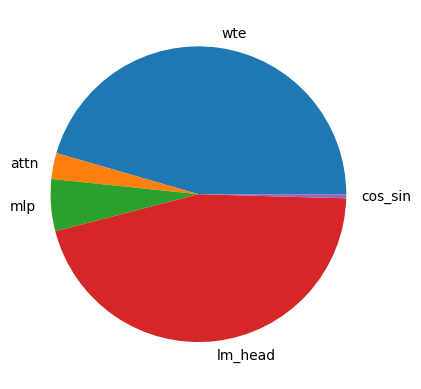

In [9]:
plt.pie(
    [n_wte_params, n_attn_params, n_mlp_params, n_lm_head_params, n_precomputed_cos_sin_params],
    labels=['wte', 'attn', 'mlp', 'lm_head', 'cos_sin']);

In [10]:
# GPU
wte_bytes = n_wte_params * 2 # on GPU, wte is set to bfloat16
attn_bytes = n_attn_params * 4
mlp_bytes = n_mlp_params * 4
lm_head_bytes = n_lm_head_params * 4
precomputed_cos_sin_bytes = n_precomputed_cos_sin_params * 2 # uses bfloat16 on CPU and GPU
wte_bytes, attn_bytes, mlp_bytes, lm_head_bytes, precomputed_cos_sin_bytes

(33554944, 4194304, 8388608, 67109888, 327680)

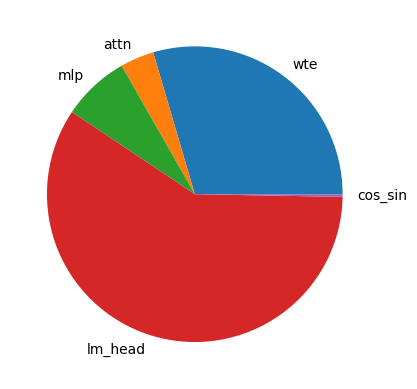

In [11]:
plt.pie(
    [wte_bytes, attn_bytes, mlp_bytes, lm_head_bytes, precomputed_cos_sin_bytes],
    labels=['wte', 'attn', 'mlp', 'lm_head', 'cos_sin']);

In [12]:
# adding in gradients and tensors the optimizers must use
wte_bytes += wte_bytes # gradient (not sure what muon is yet and if it needs to maintain other large tensors)
attn_bytes += attn_bytes * 3 # gradient, m and v in AdamW optimizer (moving averages)
mlp_bytes += mlp_bytes * 3 # gradient, m and v in AdamW optimizer 
lm_head_bytes += lm_head_bytes * 3 # gradient, m and v in AdamW optimizer

In [13]:
# Really rough...sure none of this is meaningful...more just to think about...also not sure when
# memory can be freed
other_bytes_needed = 0
other_bytes_needed += total_batch_size * 4 # x, the input batch (int32)
other_bytes_needed += total_batch_size * 8 # y, the targets (int64)
other_bytes_needed += total_batch_size * model_dim * 4 # the output of hidden layers
other_bytes_needed += total_batch_size * 4 # overall output (the logits)
other_bytes_needed += total_batch_size * model_dim * 4 # one more interim tensor (?)
other_bytes_needed

264192

In [14]:
bytes_needed = wte_bytes + attn_bytes + mlp_bytes + lm_head_bytes + precomputed_cos_sin_bytes + other_bytes_needed

In [15]:
# So for this configuration on GPU estimating need about this many bytes
print(f"{bytes_needed:,d} bytes = {bytes_needed / 1024 ** 3:2.2f} GiB")

386,472,960 bytes = 0.36 GiB


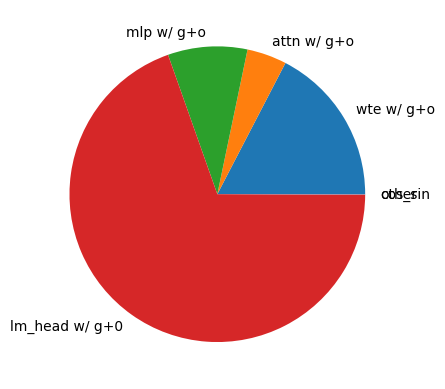

In [16]:
# pie chart of approx bytes needed including for gradients
# (of course I could be missing other big chunks that end up being needed)
plt.pie(
    [wte_bytes * 2, attn_bytes * 2, mlp_bytes * 2, lm_head_bytes * 2, precomputed_cos_sin_bytes, other_bytes_needed],
    labels=['wte w/ g+o', 'attn w/ g+o', 'mlp w/ g+o', 'lm_head w/ g+0', 'cos_sin', 'other']);

Check with actual model:

In [17]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type

In [18]:
device = autodetect_device_type()

Autodetected device type: cuda


In [19]:
model_config_kwargs = dict(sequence_len=max_seq_len, vocab_size=vocab_size, n_layer=num_layers, n_head=num_heads, n_kv_head=num_kv_heads, n_embd=model_dim)
with torch.device("meta"):
    model_config = GPTConfig(**model_config_kwargs)
    model = GPT(model_config)
model.to_empty(device=device)
model.init_weights()

In [20]:
total_params = 0
total_bytes = 0
for param in model.parameters():
    total_params += param.numel()
    total_bytes += param.untyped_storage().nbytes()
    print(f"{param.shape} has {param.numel():,d} elements using {param.untyped_storage().nbytes():,d} bytes")

torch.Size([65537, 256]) has 16,777,472 elements using 33,554,944 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([1024, 256]) has 262,144 elements using 1,048,576 bytes
torch.Size([256, 1024]) has 262,144 elements using 1,048,576 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([1024, 256]) has 262,144 elements using 1,048,576 bytes
torch.Size([256, 1024]) has 262,144 elements using 1,048,576 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,

In [21]:
total_params, total_bytes

(36700672, 113247744)

In [22]:
for name, buf in model.named_buffers():
    total_params += buf.numel()
    total_bytes += buf.untyped_storage().nbytes()
    print(name, buf.shape, buf.numel(), buf.untyped_storage().nbytes())

cos torch.Size([1, 1280, 1, 64]) 81920 163840
sin torch.Size([1, 1280, 1, 64]) 81920 163840


In [23]:
print(f"total params: {total_params:,d}")
print(f"total bytes: {total_bytes:,d} bytes = {total_bytes / 1024 ** 3:2.2f} GiB")

total params: 36,864,512
total bytes: 113,575,424 bytes = 0.11 GiB


^ But that leaves out a huge amount (gradients, optimizers, other tensors)

### Now with bigger dimensions

Repeat the cells above but with more realistic dimensions. Want to see how the pie chart looks.

In [24]:
# config from his d20 in speedrun.sh / base_train.py

depth = 20
max_seq_len = 2048

num_layers = depth
model_dim = depth * 64
num_heads = max(1, (model_dim + 127) // 128)
num_kv_heads = num_heads

vocab_size = 65537

device_batch_size = 32
total_batch_size = device_batch_size * max_seq_len

In [26]:
n_wte_params = vocab_size * model_dim
n_attn_params = num_layers * 4 * model_dim * model_dim # (c_q, c_k, c_v, c_proj)
n_mlp_params = num_layers * 2 * model_dim * 4 * model_dim # (c_fc, c_proj)
n_lm_head_params = model_dim * vocab_size
n_precomputed_cos_sin_params = 10 * max_seq_len * (model_dim // num_heads)
n_total_params = n_wte_params + n_attn_params + n_mlp_params + n_lm_head_params + n_precomputed_cos_sin_params
n_wte_params, n_attn_params, n_mlp_params, n_lm_head_params, n_precomputed_cos_sin_params

(83887360, 131072000, 262144000, 83887360, 2621440)

In [27]:
print(f"{n_total_params:,d}")

563,612,160


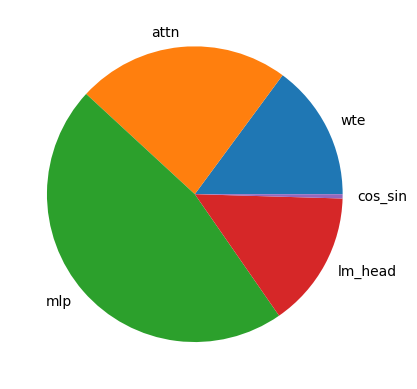

In [28]:
plt.pie(
    [n_wte_params, n_attn_params, n_mlp_params, n_lm_head_params, n_precomputed_cos_sin_params],
    labels=['wte', 'attn', 'mlp', 'lm_head', 'cos_sin']);

In [29]:
# GPU
wte_bytes = n_wte_params * 2 # on GPU, wte is set to bfloat16
attn_bytes = n_attn_params * 4
mlp_bytes = n_mlp_params * 4
lm_head_bytes = n_lm_head_params * 4
precomputed_cos_sin_bytes = n_precomputed_cos_sin_params * 2 # uses bfloat16 on CPU and GPU
wte_bytes, attn_bytes, mlp_bytes, lm_head_bytes, precomputed_cos_sin_bytes

(167774720, 524288000, 1048576000, 335549440, 5242880)

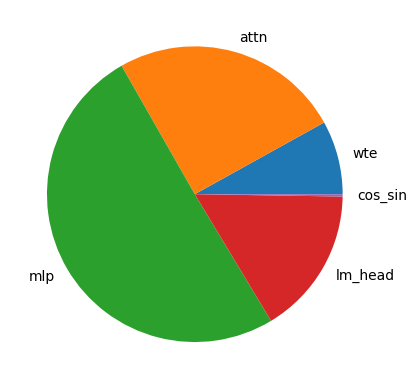

In [30]:
plt.pie(
    [wte_bytes, attn_bytes, mlp_bytes, lm_head_bytes, precomputed_cos_sin_bytes],
    labels=['wte', 'attn', 'mlp', 'lm_head', 'cos_sin']);

In [31]:
# adding in gradients and tensors the optimizers must use
wte_bytes += wte_bytes # gradient (not sure what muon is yet and if it needs to maintain other large tensors)
attn_bytes += attn_bytes * 3 # gradient, m and v in AdamW optimizer (moving averages)
mlp_bytes += mlp_bytes * 3 # gradient, m and v in AdamW optimizer 
lm_head_bytes += lm_head_bytes * 3 # gradient, m and v in AdamW optimizer

In [32]:
# Really rough...sure none of this is meaningful...more just to think about...also not sure when
# memory can be freed
other_bytes_needed = 0
other_bytes_needed += total_batch_size * 4 # x, the input batch (int32)
other_bytes_needed += total_batch_size * 8 # y, the targets (int64)
other_bytes_needed += total_batch_size * model_dim * 4 # the output of hidden layers
other_bytes_needed += total_batch_size * 4 # overall output (the logits)
other_bytes_needed += total_batch_size * model_dim * 4 # one more interim tensor (?)
other_bytes_needed

672137216

In [33]:
bytes_needed = wte_bytes + attn_bytes + mlp_bytes + lm_head_bytes + precomputed_cos_sin_bytes + other_bytes_needed

In [34]:
# So for this configuration on GPU estimating need about this many bytes
print(f"{bytes_needed:,d} bytes = {bytes_needed / 1024 ** 3:2.2f} GiB")

8,646,583,296 bytes = 8.05 GiB


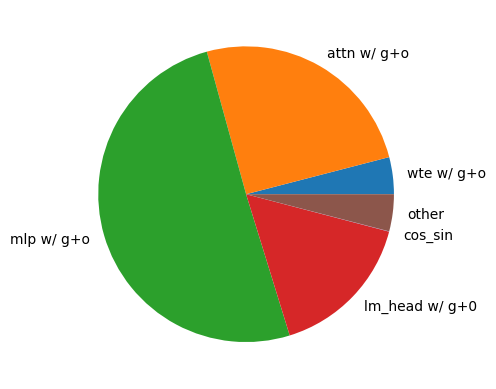

In [35]:
# pie chart of approx bytes needed including for gradients
# (of course I could be missing other big chunks that end up being needed)
plt.pie(
    [wte_bytes * 2, attn_bytes * 2, mlp_bytes * 2, lm_head_bytes * 2, precomputed_cos_sin_bytes, other_bytes_needed],
    labels=['wte w/ g+o', 'attn w/ g+o', 'mlp w/ g+o', 'lm_head w/ g+0', 'cos_sin', 'other']);

^ So even if I'm in the right ballpark for "other" it's not insigificant. Changing batch size will adjust other while leaving everything else, so maybe the idea is to make batch size as large as possible before running out of memory to maximize GPU during training.

Check with actual model:

In [36]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type

In [37]:
device = autodetect_device_type()

Autodetected device type: cuda


In [38]:
model_config_kwargs = dict(sequence_len=max_seq_len, vocab_size=vocab_size, n_layer=num_layers, n_head=num_heads, n_kv_head=num_kv_heads, n_embd=model_dim)
with torch.device("meta"):
    model_config = GPTConfig(**model_config_kwargs)
    model = GPT(model_config)
model.to_empty(device=device)
model.init_weights()

In [39]:
total_params = 0
total_bytes = 0
for param in model.parameters():
    total_params += param.numel()
    total_bytes += param.untyped_storage().nbytes()
    print(f"{param.shape} has {param.numel():,d} elements using {param.untyped_storage().nbytes():,d} bytes")

torch.Size([65537, 1280]) has 83,887,360 elements using 167,774,720 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([5120, 1280]) has 6,553,600 elements using 26,214,400 bytes
torch.Size([1280, 5120]) has 6,553,600 elements using 26,214,400 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([5120, 1280]) has 6,553,600 elements using 26,214,400 bytes
torch.Size([1280, 5120]) has 6,553,600 elements using 26,214,400 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([

In [40]:
total_params, total_bytes

(560990720, 2076188160)

In [41]:
for name, buf in model.named_buffers():
    total_params += buf.numel()
    total_bytes += buf.untyped_storage().nbytes()
    print(name, buf.shape, buf.numel(), buf.untyped_storage().nbytes())

cos torch.Size([1, 20480, 1, 64]) 1310720 2621440
sin torch.Size([1, 20480, 1, 64]) 1310720 2621440


In [42]:
print(f"total params: {total_params:,d}")
print(f"total bytes: {total_bytes:,d} bytes = {total_bytes / 1024 ** 3:2.2f} GiB")

total params: 563,612,160
total bytes: 2,081,431,040 bytes = 1.94 GiB


^ But that leaves out a huge amount (gradients, optimizers, other tensors)

### Put estimate code in a function

I want a function that will spit out my estimate so that I can try various sizes and "search" for where I run out of memory on the GPU. Also have function return model config kwargs.

In [2]:
def estimate_bytes_needed(depth=20, max_seq_len=2048, device_batch_size=32):
    num_layers = depth
    model_dim = depth * 64
    num_heads = max(1, (model_dim + 127) // 128)
    num_kv_heads = num_heads
    vocab_size = 65537
    total_batch_size = device_batch_size * max_seq_len

    n_wte_params = vocab_size * model_dim
    n_attn_params = num_layers * 4 * model_dim * model_dim # (c_q, c_k, c_v, c_proj)
    n_mlp_params = num_layers * 2 * model_dim * 4 * model_dim # (c_fc, c_proj)
    n_lm_head_params = model_dim * vocab_size
    n_precomputed_cos_sin_params = 10 * max_seq_len * (model_dim // num_heads)

    wte_bytes = n_wte_params * 2 # on GPU, wte is set to bfloat16
    attn_bytes = n_attn_params * 4
    mlp_bytes = n_mlp_params * 4
    lm_head_bytes = n_lm_head_params * 4
    precomputed_cos_sin_bytes = n_precomputed_cos_sin_params * 2 # uses bfloat16 on CPU and GPU

    # adding in gradients and tensors the optimizers must use
    wte_bytes += wte_bytes # gradient (not sure what muon is yet and if it needs to maintain other large tensors)
    attn_bytes += attn_bytes * 3 # gradient, m and v in AdamW optimizer (moving averages)
    mlp_bytes += mlp_bytes * 3 # gradient, m and v in AdamW optimizer 
    lm_head_bytes += lm_head_bytes * 3 # gradient, m and v in AdamW optimizer

    # Really rough...sure none of this is meaningful...more just to think about...also not sure when
    # memory can be freed
    other_bytes_needed = 0
    other_bytes_needed += total_batch_size * 4 # x, the input batch (int32)
    other_bytes_needed += total_batch_size * 8 # y, the targets (int64)
    other_bytes_needed += total_batch_size * model_dim * 4 # the output of hidden layers
    other_bytes_needed += total_batch_size * 4 # overall output (the logits)
    other_bytes_needed += total_batch_size * model_dim * 4 # one more interim tensor (?)

    bytes_needed = wte_bytes + attn_bytes + mlp_bytes + lm_head_bytes + precomputed_cos_sin_bytes + other_bytes_needed
    print(f"My (wrong) estimate for bytes needed: {bytes_needed:,d} bytes = {bytes_needed / 1024 ** 3:2.2f} GiB")

    model_config_kwargs = dict(
        sequence_len=max_seq_len,
        vocab_size=vocab_size,
        n_layer=num_layers,
        n_head=num_heads,
        n_kv_head=num_kv_heads,
        n_embd=model_dim
    )
    
    return bytes_needed, model_config_kwargs, vocab_size

In [3]:
bytes_needed, model_config_kwargs, vocab_size = estimate_bytes_needed(depth=20, max_seq_len=2048, device_batch_size=32)
model_config_kwargs

My (wrong) estimate for bytes needed: 8,646,583,296 bytes = 8.05 GiB


{'sequence_len': 2048,
 'vocab_size': 65537,
 'n_layer': 20,
 'n_head': 10,
 'n_kv_head': 10,
 'n_embd': 1280}

In [4]:
def create_model_and_do_one_training_step(depth, max_seq_len, device_batch_size):

    free, _ = torch.cuda.mem_get_info()
    print(f"Free memory before: {free / 1024**3:.2f} GB")
    
    device = autodetect_device_type()
    autocast_ctx = torch.amp.autocast(device_type=device, dtype=torch.bfloat16) if device == "cuda" else nullcontext()
    _, model_config_kwargs, vocab_size = estimate_bytes_needed(depth, max_seq_len, device_batch_size)
    with torch.device("meta"):
        model_config = GPTConfig(**model_config_kwargs)
        model = GPT(model_config)
    model.to_empty(device=device)
    model.init_weights()
    optimizers = model.setup_optimizers()
    x = torch.randint(0, vocab_size, (device_batch_size, max_seq_len), dtype=torch.int32, device=device)
    y = torch.randint(0, vocab_size, (device_batch_size, max_seq_len), dtype=torch.int64, device=device)
    with autocast_ctx:
        loss = model(x,y)
    loss.backward()
    for opt in optimizers:
        opt.step()

    free, _ = torch.cuda.mem_get_info()
    print(f"Free memory after: {free / 1024**3:.2f} GB")

### Figure out when we run out of memory

In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [5]:
!nvidia-smi

Tue Nov  4 16:52:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:00:05.0 Off |                  N/A |
| 30%   29C    P8             11W /  125W |       4MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
free, total = torch.cuda.mem_get_info()
print(f"Free memory: {free / 1024**3:.2f} GB")
print(f"Total memory: {total / 1024**3:.2f} GB")

Free memory: 7.68 GB
Total memory: 7.78 GB


In [7]:
create_model_and_do_one_training_step(depth=4, max_seq_len=128, device_batch_size=1)

Free memory before: 7.68 GB
Autodetected device type: cuda
My estimate for bytes needed: 386,472,960 bytes = 0.36 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(256/768) = 1.7320508075688774


W1104 16:53:05.607000 2435 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2772: UserWarning: Quadro RTX 4000 does not support bfloat16 compilation natively, skipping
  warnings.warn(


Free memory after: 7.12 GB


In [8]:
gc.collect()
torch.cuda.empty_cache()
free, total = torch.cuda.mem_get_info()
print(f"Free memory: {free / 1024**3:.2f} GB")
print(f"Total memory: {total / 1024**3:.2f} GB")

Free memory: 7.57 GB
Total memory: 7.78 GB


^ Why do we not return to the previous free memory? Won't worry about it for now.

In [10]:
# guessing this will fail
create_model_and_do_one_training_step(depth=20, max_seq_len=2048, device_batch_size=32)

Free memory before: 7.57 GB
Autodetected device type: cuda
My estimate for bytes needed: 8,646,583,296 bytes = 8.05 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1280/768) = 0.7745966692414834


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.00 GiB. GPU 0 has a total capacity of 7.78 GiB of which 2.08 GiB is free. Including non-PyTorch memory, this process has 5.70 GiB memory in use. Of the allocated memory 5.46 GiB is allocated by PyTorch, and 113.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [10]:
estimate_bytes_needed(depth=16, max_seq_len=2048, device_batch_size=32)

My estimate for bytes needed: 5,106,585,600 bytes = 4.76 GiB


(5106585600,
 {'sequence_len': 2048,
  'vocab_size': 65537,
  'n_layer': 16,
  'n_head': 8,
  'n_kv_head': 8,
  'n_embd': 1024},
 65537)

In [11]:
# guessing this will work
create_model_and_do_one_training_step(depth=16, max_seq_len=2048, device_batch_size=32)

Free memory before: 7.68 GB
Autodetected device type: cuda
My estimate for bytes needed: 5,106,585,600 bytes = 4.76 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 7.78 GiB of which 3.68 GiB is free. Including non-PyTorch memory, this process has 4.10 GiB memory in use. Of the allocated memory 3.92 GiB is allocated by PyTorch, and 70.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

No, didn't work. Maybe I'm grossly underestimating the memory needed for "interim tensors" such as to computte scaled dot product attention. Come back to that. Let's try other sizes.

In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [5]:
create_model_and_do_one_training_step(depth=16, max_seq_len=2048, device_batch_size=16)

Free memory before: 7.68 GB
Autodetected device type: cuda
My (wrong) estimate for bytes needed: 4,837,625,856 bytes = 4.51 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 7.78 GiB of which 591.81 MiB is free. Including non-PyTorch memory, this process has 7.20 GiB memory in use. Of the allocated memory 6.38 GiB is allocated by PyTorch, and 722.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [5]:
create_model_and_do_one_training_step(depth=16, max_seq_len=1024, device_batch_size=16)

Free memory before: 7.68 GB
Autodetected device type: cuda
My (wrong) estimate for bytes needed: 4,700,524,544 bytes = 4.38 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 77.81 MiB is free. Including non-PyTorch memory, this process has 7.70 GiB memory in use. Of the allocated memory 7.56 GiB is allocated by PyTorch, and 26.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [5]:
create_model_and_do_one_training_step(depth=16, max_seq_len=512, device_batch_size=16)

Free memory before: 7.68 GB
Autodetected device type: cuda
My (wrong) estimate for bytes needed: 4,631,973,888 bytes = 4.31 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 125.81 MiB is free. Including non-PyTorch memory, this process has 7.65 GiB memory in use. Of the allocated memory 7.51 GiB is allocated by PyTorch, and 29.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [5]:
create_model_and_do_one_training_step(depth=16, max_seq_len=512, device_batch_size=8)

Free memory before: 7.68 GB
Autodetected device type: cuda
My (wrong) estimate for bytes needed: 4,598,353,920 bytes = 4.28 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387


OutOfMemoryError: CUDA out of memory. Tried to allocate 514.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 331.81 MiB is free. Including non-PyTorch memory, this process has 7.45 GiB memory in use. Of the allocated memory 7.29 GiB is allocated by PyTorch, and 48.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [5]:
create_model_and_do_one_training_step(depth=16, max_seq_len=256, device_batch_size=8)

Free memory before: 7.68 GB
Autodetected device type: cuda
My (wrong) estimate for bytes needed: 4,580,888,576 bytes = 4.27 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387


W1104 17:09:29.880000 3150 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2772: UserWarning: Quadro RTX 4000 does not support bfloat16 compilation natively, skipping
  warnings.warn(


Free memory after: 1.63 GB


So the above shows I'm completely wrong about how much memory is needed. Now why?

Well, first, my thinking that the "other" category was not meaningful seems totally wrong. These interim tensors take up a lot of space.

Also, that last error where it runs out while allocating space for that logits calculation makes me realize that this part of my estimate: `other_bytes_needed += total_batch_size * 4 # overall output (the logits)` is missing vocab_size! It's not one float32 per output token (total_batch_size), it's one per vocab! So it should be `other_bytes_needed += total_batch_size * vocab_size * 4`, 65537 times greater in this case.

For the MLP, we go from model_dim to 4 x model_dim and then back to model_dim. I didn't really think about that before. That interim is going live in a tensor with this many bytes: `total_batch_size * 4 * model_dim * 4`.

Feel like I need to understand more about how memory freeing works. Come back to that.

In the errors above the last one it hits a problem here: `F.scaled_dot_product_attention(q, k, v, is_causal=True, enable_gqa=enable_gqa)`. Looking at where I tried the documentation version of that function in challenge 10, it looks like we'll need to allocate a `total_batch_size * model_dim * 4` byte tensor for the result and a `total_batch_size * max_seq_length * 4` byte tensor for attn_weight. (Not very confident in that. Only looked quickly. And also that's not necessarily how it's implemented.)

Let's write a new estimate_bytes_needed()

In [10]:
def estimate_bytes_needed(depth=20, max_seq_len=2048, device_batch_size=32):
    num_layers = depth
    model_dim = depth * 64
    num_heads = max(1, (model_dim + 127) // 128)
    num_kv_heads = num_heads
    vocab_size = 65537
    total_batch_size = device_batch_size * max_seq_len

    n_wte_params = vocab_size * model_dim
    n_attn_params = num_layers * 4 * model_dim * model_dim # (c_q, c_k, c_v, c_proj)
    n_mlp_params = num_layers * 2 * model_dim * 4 * model_dim # (c_fc, c_proj)
    n_lm_head_params = model_dim * vocab_size
    n_precomputed_cos_sin_params = 10 * max_seq_len * (model_dim // num_heads)

    wte_bytes = n_wte_params * 2 # on GPU, wte is set to bfloat16
    attn_bytes = n_attn_params * 4
    mlp_bytes = n_mlp_params * 4
    lm_head_bytes = n_lm_head_params * 4
    precomputed_cos_sin_bytes = n_precomputed_cos_sin_params * 2 # uses bfloat16 on CPU and GPU

    # adding in gradients and tensors the optimizers must use
    wte_bytes += wte_bytes # gradient (not sure what muon is yet and if it needs to maintain other large tensors)
    attn_bytes += attn_bytes * 3 # gradient, m and v in AdamW optimizer (moving averages)
    mlp_bytes += mlp_bytes * 3 # gradient, m and v in AdamW optimizer 
    lm_head_bytes += lm_head_bytes * 3 # gradient, m and v in AdamW optimizer

    # Really rough...sure none of this is meaningful...more just to think about...also not sure when
    # memory can be freed
    other_bytes_needed = 0
    
    other_bytes_needed += total_batch_size * 4 # x, the input batch (int32)
    other_bytes_needed += total_batch_size * 8 # y, the targets (int64)
    
    other_bytes_needed += total_batch_size * model_dim * 4 # the input/output of blocks
    
    other_bytes_needed += total_batch_size * model_dim * 4 # c_q result inside attn
    other_bytes_needed += total_batch_size * model_dim * 4 # c_k result inside attn
    other_bytes_needed += total_batch_size * model_dim * 4 # c_v result inside attn
    other_bytes_needed += total_batch_size * max_seq_len * 4 # attn_weight inside F.scaled_dot_product_attention
    other_bytes_needed += total_batch_size * model_dim * 4 # for result of F.scaled_dot_product_attention
    
    other_bytes_needed += total_batch_size * 4 * model_dim * 4 # the interim inside the MLP
    
    other_bytes_needed += total_batch_size * vocab_size * 4 # overall output (the logits), fixed from above

    bytes_needed = wte_bytes + attn_bytes + mlp_bytes + lm_head_bytes + precomputed_cos_sin_bytes + other_bytes_needed
    print(f"My (prob still wrong) estimate for bytes needed: {bytes_needed:,d} bytes = {bytes_needed / 1024 ** 3:2.2f} GiB")

    model_config_kwargs = dict(
        sequence_len=max_seq_len,
        vocab_size=vocab_size,
        n_layer=num_layers,
        n_head=num_heads,
        n_kv_head=num_kv_heads,
        n_embd=model_dim
    )
    
    return bytes_needed, model_config_kwargs, vocab_size

In [2]:
estimate_bytes_needed(depth=20, max_seq_len=2048, device_batch_size=32);

My (prob still wrong) estimate for bytes needed: 28,712,133,632 bytes = 26.74 GiB


In [3]:
estimate_bytes_needed(depth=16, max_seq_len=256, device_batch_size=8);

My (prob still wrong) estimate for bytes needed: 5,178,576,896 bytes = 4.82 GiB


In [26]:
estimate_bytes_needed(depth=16, max_seq_len=512, device_batch_size=8);

My (prob still wrong) estimate for bytes needed: 5,797,924,864 bytes = 5.40 GiB


In [27]:
estimate_bytes_needed(depth=16, max_seq_len=512, device_batch_size=16);

My (prob still wrong) estimate for bytes needed: 7,031,115,776 bytes = 6.55 GiB


In [28]:
estimate_bytes_needed(depth=16, max_seq_len=512, device_batch_size=32);

My (prob still wrong) estimate for bytes needed: 9,497,497,600 bytes = 8.85 GiB


Let's try a few and see if we're closer to when we actually run out of memory

In [3]:
# copied from above

def create_model_and_do_one_training_step(depth, max_seq_len, device_batch_size):

    free, _ = torch.cuda.mem_get_info()
    print(f"Free memory before: {free / 1024**3:.2f} GB")
    
    device = autodetect_device_type()
    autocast_ctx = torch.amp.autocast(device_type=device, dtype=torch.bfloat16) if device == "cuda" else nullcontext()
    _, model_config_kwargs, vocab_size = estimate_bytes_needed(depth, max_seq_len, device_batch_size)
    with torch.device("meta"):
        model_config = GPTConfig(**model_config_kwargs)
        model = GPT(model_config)
    model.to_empty(device=device)
    model.init_weights()
    optimizers = model.setup_optimizers()
    x = torch.randint(0, vocab_size, (device_batch_size, max_seq_len), dtype=torch.int32, device=device)
    y = torch.randint(0, vocab_size, (device_batch_size, max_seq_len), dtype=torch.int64, device=device)
    with autocast_ctx:
        loss = model(x,y)
    loss.backward()
    for opt in optimizers:
        opt.step()

    free, _ = torch.cuda.mem_get_info()
    print(f"Free memory after: {free / 1024**3:.2f} GB")

In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [4]:
create_model_and_do_one_training_step(depth=16, max_seq_len=512, device_batch_size=16)

Free memory before: 7.68 GB
Autodetected device type: cuda
My (prob still wrong) estimate for bytes needed: 7,031,115,776 bytes = 6.55 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 125.81 MiB is free. Including non-PyTorch memory, this process has 7.65 GiB memory in use. Of the allocated memory 7.51 GiB is allocated by PyTorch, and 29.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [4]:
create_model_and_do_one_training_step(depth=16, max_seq_len=512, device_batch_size=8)

Free memory before: 7.68 GB
Autodetected device type: cuda
My (prob still wrong) estimate for bytes needed: 5,797,924,864 bytes = 5.40 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387


OutOfMemoryError: CUDA out of memory. Tried to allocate 514.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 331.81 MiB is free. Including non-PyTorch memory, this process has 7.45 GiB memory in use. Of the allocated memory 7.29 GiB is allocated by PyTorch, and 48.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

One thing I'm not doing, but the actual training does, is compile the model first. From some quick reading it looks like that does not reduce memory.

Ooh, from asking ChatGPT "When running the forward of a model, will python/pytorch re-use / free up memory as needed?," it pointed out that "In training with autograd, intermediates needed for backprop must be kept until backward() finishes." Won't all of them be needed then?

In [2]:
def estimate_bytes_needed(depth=20, max_seq_len=2048, device_batch_size=32):
    num_layers = depth
    model_dim = depth * 64
    num_heads = max(1, (model_dim + 127) // 128)
    num_kv_heads = num_heads
    vocab_size = 65537
    total_batch_size = device_batch_size * max_seq_len

    n_wte_params = vocab_size * model_dim
    n_attn_params = num_layers * 4 * model_dim * model_dim # (c_q, c_k, c_v, c_proj)
    n_mlp_params = num_layers * 2 * model_dim * 4 * model_dim # (c_fc, c_proj)
    n_lm_head_params = model_dim * vocab_size
    n_precomputed_cos_sin_params = 10 * max_seq_len * (model_dim // num_heads)

    wte_bytes = n_wte_params * 2 # on GPU, wte is set to bfloat16
    attn_bytes = n_attn_params * 4
    mlp_bytes = n_mlp_params * 4
    lm_head_bytes = n_lm_head_params * 4
    precomputed_cos_sin_bytes = n_precomputed_cos_sin_params * 2 # uses bfloat16 on CPU and GPU

    # adding in gradients and tensors the optimizers must use
    wte_bytes += wte_bytes # gradient (not sure what muon is yet and if it needs to maintain other large tensors)
    attn_bytes += attn_bytes * 3 # gradient, m and v in AdamW optimizer (moving averages)
    mlp_bytes += mlp_bytes * 3 # gradient, m and v in AdamW optimizer 
    lm_head_bytes += lm_head_bytes * 3 # gradient, m and v in AdamW optimizer

    # Really rough...sure none of this is meaningful...more just to think about...also not sure when
    # memory can be freed
    other_bytes_needed = 0
    
    other_bytes_needed += total_batch_size * 4 # x, the input batch (int32)
    other_bytes_needed += total_batch_size * 8 # y, the targets (int64)

    bytes_needed_to_compute_block = 0
    bytes_needed_to_compute_block += total_batch_size * model_dim * 4 # the input/output of blocks
    bytes_needed_to_compute_block += total_batch_size * model_dim * 4 # c_q result inside attn
    bytes_needed_to_compute_block += total_batch_size * model_dim * 4 # c_k result inside attn
    bytes_needed_to_compute_block += total_batch_size * model_dim * 4 # c_v result inside attn
    bytes_needed_to_compute_block += total_batch_size * max_seq_len * 4 # attn_weight inside F.scaled_dot_product_attention
    bytes_needed_to_compute_block += model_dim * 4 # for result of F.scaled_dot_product_attention
    bytes_needed_to_compute_block += total_batch_size * 4 * model_dim * 4 # the interim inside the MLP

    other_bytes_needed += num_layers * bytes_needed_to_compute_block
    
    other_bytes_needed += total_batch_size * vocab_size * 4 # overall output (the logits), fixed from above

    bytes_needed = wte_bytes + attn_bytes + mlp_bytes + lm_head_bytes + precomputed_cos_sin_bytes + other_bytes_needed
    print(f"My (prob still wrong) estimate for bytes needed: {bytes_needed:,d} bytes = {bytes_needed / 1024 ** 3:2.2f} GiB")

    model_config_kwargs = dict(
        sequence_len=max_seq_len,
        vocab_size=vocab_size,
        n_layer=num_layers,
        n_head=num_heads,
        n_kv_head=num_kv_heads,
        n_embd=model_dim
    )
    
    return bytes_needed, model_config_kwargs, vocab_size

In [9]:
# look at the config that worked above
estimate_bytes_needed(depth=16, max_seq_len=256, device_batch_size=8);

My (prob still wrong) estimate for bytes needed: 6,208,344,064 bytes = 5.78 GiB


In [10]:
estimate_bytes_needed(depth=16, max_seq_len=512, device_batch_size=16);

My (prob still wrong) estimate for bytes needed: 11,275,816,960 bytes = 10.50 GiB


In [4]:
estimate_bytes_needed(depth=16, max_seq_len=512, device_batch_size=6);

My (prob still wrong) estimate for bytes needed: 7,081,431,040 bytes = 6.60 GiB


In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [5]:
create_model_and_do_one_training_step(depth=16, max_seq_len=512, device_batch_size=6)

Free memory before: 7.68 GB
Autodetected device type: cuda
My (prob still wrong) estimate for bytes needed: 7,081,431,040 bytes = 6.60 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387


OutOfMemoryError: CUDA out of memory. Tried to allocate 770.00 MiB. GPU 0 has a total capacity of 7.78 GiB of which 625.81 MiB is free. Including non-PyTorch memory, this process has 7.17 GiB memory in use. Of the allocated memory 7.02 GiB is allocated by PyTorch, and 33.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

^ Ran out of memory on backward

In [1]:
## restart kernel ##
import torch
import gc
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type
torch.cuda.memory_allocated() # should be 0

0

In [4]:
create_model_and_do_one_training_step(depth=16, max_seq_len=512, device_batch_size=4)

Free memory before: 7.68 GB
Autodetected device type: cuda
My (prob still wrong) estimate for bytes needed: 6,242,553,856 bytes = 5.81 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387


W1104 22:48:25.677000 2824 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2772: UserWarning: Quadro RTX 4000 does not support bfloat16 compilation natively, skipping
  warnings.warn(


Free memory after: 1.37 GB


### A few thoughts on what to do next...

1) It's annoying to keep restarting kernel. Make a create_model_and_do_one_training_step script.
2) Instrument the model to show torch.cuda.memory_allocated() along the way (even though as we saw above you can't perfectly judge by that)
3) See if it's possible to get a complete list of allocated tensors from torch or the python garbage collector so I can see what they are each point
4) Create a toy model that does have intermediate tensors to understand memory requirements for forward passes with autograd and when there is an optimier so I can build an intuition for a simpler case
5) Read some stuff / ask ChatGPT about estimating total memory requirements
6) Just move on

Let me at least do 1, then might skip to 5 and 6.

### Script

Wrote `create_model_and_do_one_training_step.py`

In [4]:
!python create_model_and_do_one_training_step.py

usage: create_model_and_do_one_training_step.py [-h] --depth DEPTH
                                                --max-seq-len MAX_SEQ_LEN
                                                --device-batch-size
                                                DEVICE_BATCH_SIZE
create_model_and_do_one_training_step.py: error: the following arguments are required: --depth, --max-seq-len, --device-batch-size


In [8]:
!python create_model_and_do_one_training_step.py --depth 16 --max-seq-len 512 --device-batch-size=4

Free memory before: 7.68 GB
Autodetected device type: cuda
{'sequence_len': 512, 'vocab_size': 65537, 'n_layer': 16, 'n_head': 8, 'n_kv_head': 8, 'n_embd': 1024}
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387
W1105 18:41:27.016000 2616 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2772: UserWarning: Quadro RTX 4000 does not support bfloat16 compilation natively, skipping
  warnings.warn(
Free memory after: 1.37 GB


In [9]:
!python create_model_and_do_one_training_step.py --depth 16 --max-seq-len 512 --device-batch-size=5

Free memory before: 7.68 GB
Autodetected device type: cuda
{'sequence_len': 512, 'vocab_size': 65537, 'n_layer': 16, 'n_head': 8, 'n_kv_head': 8, 'n_embd': 1024}
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387
W1105 18:42:31.130000 2693 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2772: UserWarning: Quadro RTX 4000 does not support bfloat16 compilation natively, skipping
  warnings.warn(
Free memory after: 0.21 GB


In [15]:
!python create_model_and_do_one_training_step.py --depth 16 --max-seq-len 1024 --device-batch-size=4

Free memory before: 7.68 GB
Autodetected device type: cuda
{'sequence_len': 1024, 'vocab_size': 65537, 'n_layer': 16, 'n_head': 8, 'n_kv_head': 8, 'n_embd': 1024}
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387
Traceback (most recent call last):
  File "/home/paperspace/nanogpt-learning/challenge-15-understand-memory-needed/create_model_and_do_one_training_step.py", line 59, in <module>
    create_model_and_do_one_training_step(args.depth, args.max_seq_len, args.device_batch_size)
  File "/home/paperspace/nanogpt-learning/challenge-15-understand-memory-needed/create_model_and_do_one_training_step.py", line 43, in create_model_and_do_one_training_step
    loss = model(x,y)
  File "/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1775, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/nn/modu

In [16]:
!python create_model_and_do_one_training_step.py --depth 16 --max-seq-len 512 --device-batch-size=1

Free memory before: 7.68 GB
Autodetected device type: cuda
{'sequence_len': 512, 'vocab_size': 65537, 'n_layer': 16, 'n_head': 8, 'n_kv_head': 8, 'n_embd': 1024}
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387
W1105 18:45:35.030000 2844 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2772: UserWarning: Quadro RTX 4000 does not support bfloat16 compilation natively, skipping
  warnings.warn(
Free memory after: 3.58 GB


In [17]:
!python create_model_and_do_one_training_step.py --depth 16 --max-seq-len 1024 --device-batch-size=1

Free memory before: 7.68 GB
Autodetected device type: cuda
{'sequence_len': 1024, 'vocab_size': 65537, 'n_layer': 16, 'n_head': 8, 'n_kv_head': 8, 'n_embd': 1024}
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387
W1105 18:46:18.751000 2915 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2772: UserWarning: Quadro RTX 4000 does not support bfloat16 compilation natively, skipping
  warnings.warn(
Free memory after: 3.42 GB


In [27]:
!python create_model_and_do_one_training_step.py --depth 16 --max-seq-len 1024 --device-batch-size=2

Before: Torch memory allocated: 0.00 GiB (free = 7.68 GiB)
Autodetected device type: cuda
{'sequence_len': 1024, 'vocab_size': 65537, 'n_layer': 16, 'n_head': 8, 'n_kv_head': 8, 'n_embd': 1024}
After creating model: Torch memory allocated: 1.25 GiB (free = 6.43 GiB)
After initializing weights: Torch memory allocated: 1.13 GiB (free = 6.27 GiB)
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387
After setting up optimizers: Torch memory allocated: 1.13 GiB (free = 6.27 GiB)
After creating x and y: Torch memory allocated: 1.13 GiB (free = 6.27 GiB)
After forward: Torch memory allocated: 5.22 GiB (free = 1.37 GiB)
After backward: Torch memory allocated: 2.27 GiB (free = 0.87 GiB)
After optimizer 0 step: Torch memory allocated: 3.02 GiB (free = 0.87 GiB)
W1105 19:03:25.518000 3859 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/home/paperspace/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/_inductor/com

^ does look like the muon optimizer used up a bunch of memory and I ignored that in my esimate

In [29]:
!python create_model_and_do_one_training_step.py --depth 16 --max-seq-len 1024 --device-batch-size=4

Before: Torch memory allocated: 0.00 GiB (free = 7.68 GiB)
Autodetected device type: cuda
{'sequence_len': 1024, 'vocab_size': 65537, 'n_layer': 16, 'n_head': 8, 'n_kv_head': 8, 'n_embd': 1024}
After creating model: Torch memory allocated: 1.25 GiB (free = 6.43 GiB)
After initializing weights: Torch memory allocated: 1.13 GiB (free = 6.27 GiB)
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387
After setting up optimizers: Torch memory allocated: 1.13 GiB (free = 6.27 GiB)
After creating x and y: Torch memory allocated: 1.13 GiB (free = 6.27 GiB)
Traceback (most recent call last):
  File "/home/paperspace/nanogpt-learning/challenge-15-understand-memory-needed/create_model_and_do_one_training_step.py", line 64, in <module>
    create_model_and_do_one_training_step(args.depth, args.max_seq_len, args.device_batch_size)
  File "/home/paperspace/nanogpt-learning/challenge-15-understand-memory-needed/create_model_and_do_one_training_step.py", line 46

^ as expected with the same depth and max seq length as the previous try that worked, memory allocated up to the forward step is the same (or prob around the same since x and y should be bigger). But with the bigger batch size the forward fails.

For now, add some quick and dirty memory logging to my_gpt.py which I'll undo

In [32]:
!python create_model_and_do_one_training_step.py --depth 16 --max-seq-len 1024 --device-batch-size=4

Before: Torch memory allocated: 0.00 GiB (free = 7.68 GiB)
Autodetected device type: cuda
{'sequence_len': 1024, 'vocab_size': 65537, 'n_layer': 16, 'n_head': 8, 'n_kv_head': 8, 'n_embd': 1024}
After creating model: Torch memory allocated: 1.25 GiB (free = 6.43 GiB)
After initializing weights: Torch memory allocated: 1.13 GiB (free = 6.27 GiB)
Scaling the LR for the AdamW parameters proportional to 1/sqrt(1024/768) = 0.8660254037844387
After setting up optimizers: Torch memory allocated: 1.13 GiB (free = 6.27 GiB)
After creating x and y: Torch memory allocated: 1.13 GiB (free = 6.27 GiB)
After wte: Torch memory allocated: 1.14 GiB (free = 6.27 GiB)
After norm: Torch memory allocated: 1.14 GiB (free = 6.27 GiB)
   After MLP c_fc: Torch memory allocated: 1.42 GiB (free = 6.01 GiB)
   After MLP RELU squared: Torch memory allocated: 1.54 GiB (free = 6.01 GiB)
   After MLP c_proj: Torch memory allocated: 1.53 GiB (free = 6.01 GiB)
After block: Torch memory allocated: 1.53 GiB (free = 6.01 G